In [1]:
import pandas as pd
from neuralforecast.models import PatchTST, TFT, LSTM, GRU, TimesNet
from neuralforecast.core import NeuralForecast
from utilsforecast.plotting import plot_series
import matplotlib.pyplot as plt
import torch

# Load Data


In [2]:
# Options
load_model = False
training = True

assert load_model or training == True

In [3]:
price_data_path = '../../price.csv'
price_data = pd.read_csv(price_data_path)


# TODO: integrate the LLM processed data with the price data

Y_df = pd.DataFrame(price_data)
def replace_non_numeric(value):
    if isinstance(value, str) and not value.replace('.', '', 1).replace('-', '', 1).isdigit():
        return 0.5
    return value

for column in ['Rank', 'Risk', 'Sentiment','Rank','Risk','Sentiment']:
    Y_df[column] = Y_df[column].apply(replace_non_numeric)
    
print(Y_df.head(5))
n_time = len(Y_df['ds'].unique())
val_size = int(0.2 * n_time)
test_size = int(0.2 * n_time)

   Unnamed: 0  ds        Open        High         Low           y      Volume  \
0           0   0  187.800994  188.440002  186.009994  186.189895  21173591.0   
1           1   1  186.179992  186.904998  185.184295  186.804992   9010595.0   
2           2   2  186.800003  187.350006  186.570007  186.615005   6143754.0   
3           3   3  186.615005  187.039993  185.259994  185.294998   5381701.0   
4           4   4  185.289993  185.539993  184.229995  184.494995   7228643.0   

   Rank Risk Sentiment unique_id  week_day  
0   0.8  0.2       0.7      AAPL         1  
1   0.3  0.4       0.3      AAPL         1  
2   0.5  0.5       0.5      AAPL         1  
3   0.8  0.2       0.8      AAPL         1  
4  0.35  0.2      0.35      AAPL         1  


In [4]:
# plot_series(Y_df.groupby('unique_id', group_keys=False).apply(lambda g:g.tail(100)))


# Model


In [5]:
horizon = 3  # 7 hours per day

models = [TFT(
    h=horizon,  # forecasting horizon
    input_size=horizon * 10,  # input sizetsih
    max_steps=1000,
    val_check_steps=100,
    early_stop_patience_steps=5,
    enable_checkpointing=True,
    hist_exog_list=['Open', 'High', 'Low', 'Volume','Rank','Risk','Sentiment'],
),
    PatchTST(
        h=horizon,
        input_size=horizon * 10,
        max_steps=1000,
        val_check_steps=100,
        enable_checkpointing=True
    ),
    TimesNet(
        h=horizon,
        input_size=horizon * 10,
        max_steps=1000,
        val_check_steps=100,
        enable_checkpointing=True,
        early_stop_patience_steps=5
    )
]

nf = NeuralForecast(
    models=models,
    freq=1  # hourly frequency
)

if load_model:
    print('Load Model')
    nf = NeuralForecast.load(path='./ckpts/')

    if not training:
        Y_hat_df = nf.predict().reset_index()

if training:
    print('Start training')
    Y_hat_df = nf.cross_validation(df=Y_df,
                                   val_size=val_size,
                                   test_size=test_size,
                                   n_windows=None)

# Y_hat_df = nf.cross_validation(
#     df=Y_df,
#     n_windows=3,
#     val_size=val_size,
#     step_size=horizon,
#     refit=1
# )

Seed set to 1
/root/miniconda3/lib/python3.12/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
Seed set to 1
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Start training


You are using a CUDA device ('NVIDIA GeForce RTX 4090 D') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 2.3 K  | train
4 | static_encoder          | StaticCovariateEncoder   | 331 K  | train
5 | temporal_encoder        | TemporalCovariateEncoder | 1.2 M  | train
6 | tempo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 401 K  | train
-----------------------------------------------------------
401 K     Trainable params
3         Non-trainable params
401 K     Total params
1.605     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 1.0 K  | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.755    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/root/miniconda3/lib/python3.12/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [6]:
horizon = 3  # 7 hours per day

no_news_models = [TFT(
    h=horizon,  # forecasting horizon
    input_size=horizon * 7,  # input sizetsih
    max_steps=1000,
    val_check_steps=100,
    early_stop_patience_steps=5,
    enable_checkpointing=True,
    hist_exog_list=['Open', 'High', 'Low', 'Volume','Rank','Risk','Sentiment'],
),
    PatchTST(
        h=horizon,
        input_size=horizon * 7,
        max_steps=1000,
        val_check_steps=100,
        enable_checkpointing=True
    ),
    TimesNet(
        h=horizon,
        input_size=horizon * 7,
        max_steps=1000,
        val_check_steps=100,
        enable_checkpointing=True,
        early_stop_patience_steps=5
    )
]

no_news_nf = NeuralForecast(
    models=no_news_models,
    freq=1  # hourly frequency
)

if load_model:
    print('Load Model')
    no_news_nf = NeuralForecast.load(path='./ckpts/')

    if not training:
        Y_hat_df_no_news = nf.predict().reset_index()

if training:
    print('Start training')
    Y_hat_df_no_news = no_news_nf.cross_validation(df=Y_df,
                                   val_size=val_size,
                                   test_size=test_size,
                                   n_windows=None)

Seed set to 1
/root/miniconda3/lib/python3.12/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
Seed set to 1
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 2.3 K  | train
4 | static_encoder          | StaticCovariateEncoder   | 331 K  | train
5 | temporal_encoder        | TemporalCovariateEncoder | 1.2 M  | train
6 | temporal_fusion_decoder

Start training


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 400 K  | train
-----------------------------------------------------------
400 K     Trainable params
3         Non-trainable params
400 K     Total params
1.603     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 528    | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.753    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/root/miniconda3/lib/python3.12/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [7]:
Y_hat_df['WeighedAverage'] = (Y_hat_df['PatchTST'] * 0.5 + Y_hat_df['TFT'] * 0.2 + Y_hat_df['TimesNet'] * 0.3)
Y_hat_df_no_news['WeighedAverage'] = (Y_hat_df_no_news['PatchTST'] * 0.5 + Y_hat_df_no_news['TFT'] * 0.2 + Y_hat_df_no_news['TimesNet'] * 0.3)

# Save Checkpoints

In [8]:
nf.save(path='./ckpts/',
        save_dataset=True,
        overwrite=True,
        )

# Plot 

In [9]:
Y_hat_df.reset_index(inplace=True)
Y_hat_df.rename(columns={'y': 'actual'}, inplace=True)
print(Y_hat_df.head(5))

  unique_id   ds  cutoff         TFT    PatchTST    TimesNet      actual  \
0      AAPL  724     723  189.294876  189.812454  189.296661  190.149993   
1      AAPL  725     723  190.343262  189.444595  189.206726  190.089996   
2      AAPL  726     723  191.789230  188.731628  188.809006  190.000000   
3      AAPL  725     724  189.879211  189.722488  189.518829  190.089996   
4      AAPL  726     724  191.531143  189.577103  189.297134  190.000000   

   WeighedAverage  
0      189.554199  
1      189.552979  
2      189.366364  
3      189.692734  
4      189.883926  


In [13]:
Y_hat_df_no_news.reset_index(inplace=True)
Y_hat_df_no_news.rename(columns={'y': 'actual'}, inplace=True)
print(Y_hat_df_no_news.head(5))

   index unique_id   ds  cutoff         TFT    PatchTST    TimesNet  \
0      0      AAPL  724     723  190.426590  188.742493  189.568237   
1      1      AAPL  725     723  190.848160  187.654144  186.879440   
2      2      AAPL  726     723  190.867737  187.012436  187.522736   
3      3      AAPL  725     724  189.865524  189.411469  190.383545   
4      4      AAPL  726     724  190.195847  188.888687  190.031586   

       actual  WeighedAverage  
0  190.149993      189.327042  
1  190.089996      188.060547  
2  190.000000      187.936584  
3  190.089996      189.793900  
4  190.000000      189.492996  


In [14]:
# Y_hat_df.drop(columns=['index'], inplace=True)
Y_hat_df.loc[:, Y_hat_df.columns != 'cutoff']

,unique_id,ds,TFT,PatchTST,TimesNet,actual,WeighedAverage
0,AAPL,724,189.294876,189.812454,189.296661,190.149993,189.554199
1,AAPL,725,190.343262,189.444595,189.206726,190.089996,189.552979
2,AAPL,726,191.789230,188.731628,188.809006,190.000000,189.366364
3,AAPL,725,189.879211,189.722488,189.518829,190.089996,189.692734
4,AAPL,726,191.531143,189.577103,189.297134,190.000000,189.883926
...,...,...,...,...,...,...,...
529,AAPL,901,214.653824,213.610580,213.864639,213.054992,213.895447
530,AAPL,902,214.678635,213.389038,213.580490,210.610000,213.704407
531,AAPL,901,213.787506,213.139420,213.498566,213.054992,213.376785
532,AAPL,902,213.734772,212.860672,213.356873,210.610000,213.184357


In [15]:
print(len(Y_hat_df))

534


/tmp/ipykernel_1797/1231652958.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_plot_no_news = Y_plot[Y_plot_no_news['cutoff'].isin(cutoffs_no_news)]


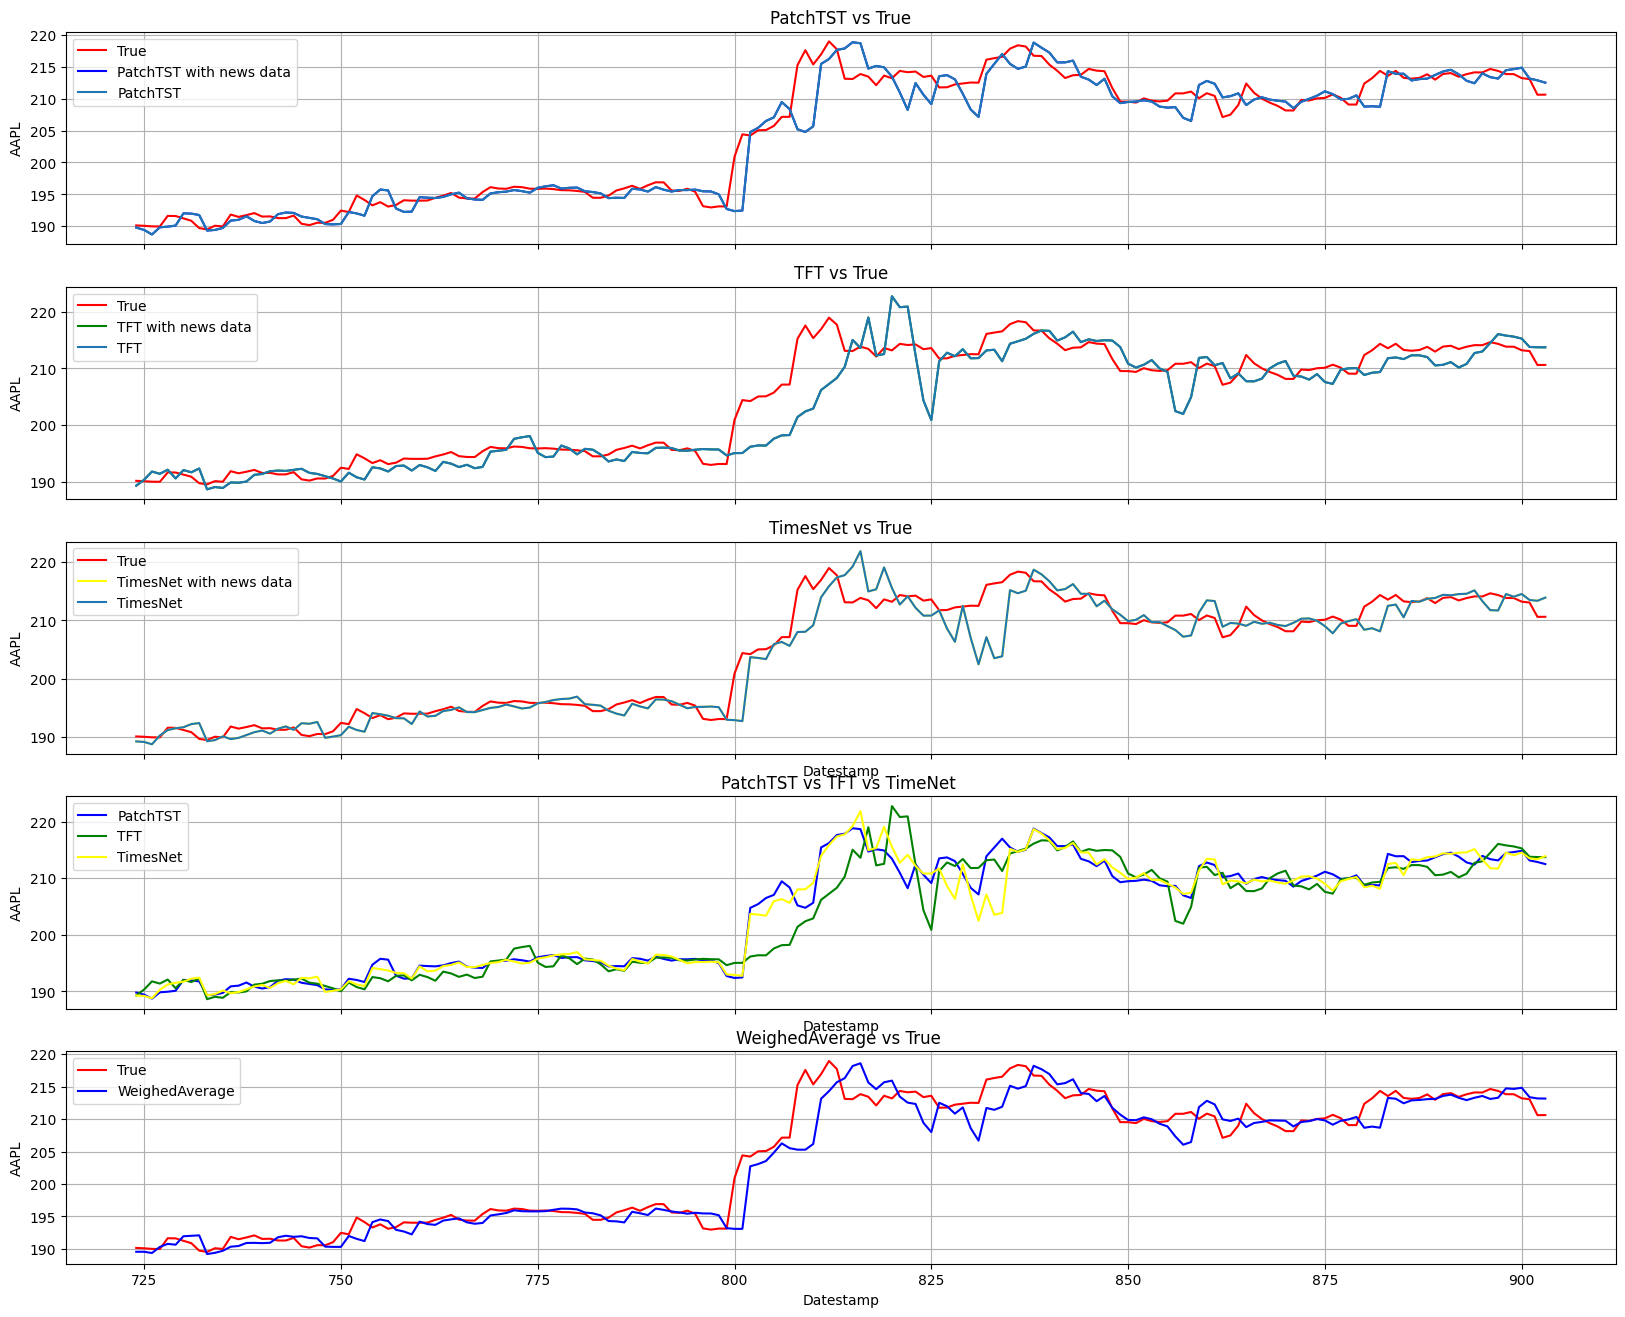

In [16]:
plot_code = 'AAPL'

# choose the stock to plot
if not training:
    Y_plot = pd.concat([Y_df.groupby('unique_id', group_keys=False).apply(lambda g: g.tail(100)), Y_hat_df])
    Y_plot = Y_plot[Y_plot['unique_id'] == plot_code]
    
    Y_plot_no_news = pd.concat([Y_df.groupby('unique_id', group_keys=False).apply(lambda g: g.tail(100)), Y_hat_df_no_news])
    Y_plot_no_news = Y_plot_no_news[Y_plot_no_news['unique_id'] == plot_code]

else:
    Y_plot = Y_hat_df[Y_hat_df['unique_id'] == plot_code]
    cutoffs = Y_hat_df['cutoff'].unique()[::horizon]
    Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]
    
    Y_plot_no_news = Y_hat_df_no_news[Y_hat_df['unique_id'] == plot_code]
    cutoffs_no_news = Y_hat_df_no_news['cutoff'].unique()[::horizon]
    Y_plot_no_news = Y_plot[Y_plot_no_news['cutoff'].isin(cutoffs_no_news)]

fig, axs = plt.subplots(5, 1, figsize=(20, 16), sharex=True)

# Plotting the actual line and the PatchTST prediction
axs[0].plot(Y_plot['ds'], Y_plot['actual'], label='True', color='red')
axs[0].plot(Y_plot['ds'], Y_plot['PatchTST'], label='PatchTST with news data', color='blue')
axs[0].plot(Y_plot_no_news['ds'], Y_plot_no_news['PatchTST'], label='PatchTST')
axs[0].set_ylabel(plot_code)
axs[0].grid()
axs[0].legend()
axs[0].set_title('PatchTST vs True')

# Plotting the actual line and the TFT prediction
axs[1].plot(Y_plot['ds'], Y_plot['actual'], label='True', color='red')
axs[1].plot(Y_plot['ds'], Y_plot['TFT'], label='TFT with news data', color='green')
axs[1].plot(Y_plot_no_news['ds'], Y_plot_no_news['TFT'], label='TFT')
axs[1].set_ylabel(plot_code)
axs[1].grid()
axs[1].legend()
axs[1].set_title('TFT vs True')

# Plotting the actual line and the LSTM prediction
axs[2].plot(Y_plot['ds'], Y_plot['actual'], label='True', color='red')
axs[2].plot(Y_plot['ds'], Y_plot['TimesNet'], label='TimesNet with news data',color='yellow')
axs[2].plot(Y_plot_no_news['ds'], Y_plot_no_news['TimesNet'], label='TimesNet')
axs[2].set_xlabel('Datestamp')
axs[2].set_ylabel(plot_code)
axs[2].grid()
axs[2].legend()
axs[2].set_title('TimesNet vs True')

# Plotting the actual line and the LSTM prediction
axs[3].plot(Y_plot['ds'], Y_plot['PatchTST'], label='PatchTST',color='blue')
axs[3].plot(Y_plot['ds'], Y_plot['TFT'], label='TFT',color='green')
axs[3].plot(Y_plot['ds'], Y_plot['TimesNet'], label='TimesNet',color='yellow')
axs[3].set_xlabel('Datestamp')
axs[3].set_ylabel(plot_code)
axs[3].grid()
axs[3].legend()
axs[3].set_title('PatchTST vs TFT vs TimeNet ')

# Plotting the actual line and the LSTM prediction
axs[4].plot(Y_plot['ds'], Y_plot['actual'], label='True', color='red')
axs[4].plot(Y_plot['ds'], Y_plot['WeighedAverage'], label='WeighedAverage',color='blue')
axs[4].set_xlabel('Datestamp')
axs[4].set_ylabel(plot_code)
axs[4].grid()
axs[4].legend()
axs[4].set_title('WeighedAverage vs True ')


# Save the figure
plt.savefig(f'../img/result_{plot_code}.png')
plt.show()

# Rough Evaluation

In [17]:
from neuralforecast.losses.numpy import mae

mae_patch_tst = mae(Y_hat_df['actual'], Y_hat_df['PatchTST'])
mae_tft = mae(Y_hat_df['actual'], Y_hat_df['TFT'])
mae_lstm = mae(Y_hat_df['actual'], Y_hat_df['TimesNet'])
mae_avg = mae(Y_hat_df['actual'], Y_hat_df['WeighedAverage'])
print("Models performance in dataset with news:")
print(f'PatchTST: {mae_patch_tst:.4f}')
print(f'TFT: {mae_tft:.4f}')
print(f'TimesNet: {mae_lstm:.4f}')
print(f'WeighedAverage: {mae_avg:.4f}')

Models performance in dataset with news:
PatchTST: 1.4715
TFT: 2.4741
TimesNet: 1.6927
WeighedAverage: 1.5069


In [18]:
mae_patch_tst2 = mae(Y_plot_no_news['actual'], Y_plot_no_news['PatchTST'])
mae_tft2 = mae(Y_plot_no_news['actual'], Y_plot_no_news['TFT'])
mae_lstm2 = mae(Y_plot_no_news['actual'], Y_plot_no_news['TimesNet'])
mae_avg2 = mae(Y_plot_no_news['actual'], Y_plot_no_news['WeighedAverage'])
print("Models performance in dataset without news:")
print(f'PatchTST: {mae_patch_tst2:.4f}')
print(f'TFT: {mae_tft2:.4f}')
print(f'TimesNet: {mae_lstm2:.4f}')
print(f'WeighedAverage: {mae_avg2:.4f}')

Models performance in dataset without news:
PatchTST: 1.5832
TFT: 2.5301
TimesNet: 1.8311
WeighedAverage: 1.6246
